In [359]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [360]:
import numpy
import torch
import torchvision
import typing
import numpy

from holo.prettyFormats import prettyPrint, prettyTime
from holo.__typing import assertIsinstance

In [361]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

using device: cuda:0


In [362]:
import handleDatas
import train
import basicModels
import MoE_models
import MoE_models.paper2
import modelsParameters

def cell():
    global handleDatas, train, MoE_models, basicModels, modelsParameters
    import importlib
    handleDatas = importlib.reload(handleDatas)
    train = importlib.reload(train)
    basicModels = importlib.reload(basicModels)
    modelsParameters = importlib.reload(modelsParameters)
    MoE_models.paper2 = importlib.reload(MoE_models.paper2)

cell();

In [363]:
#datashandler = handleDatas.Cifar100_Datas(
#    fromTrainSource=None, maxSamples=None, trainProp=0.8,
#    batchSizeTrain=256, batchSizeTest=256)
globals().pop("datasHandler", None)
datasHandler = handleDatas.HandleImagesClassifDatas.merge(
    #handleDatas.MNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.FashionMNIST_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.Cifar10_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    #handleDatas.Cifar100_Datas(
    #    fromTrainSource=None, maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    handleDatas.ImageNette_Datas(
        fromTrainSource="val", size="160px", maxSamples=None, trainProp=0.8, batchSizeTrain=256, batchSizeTest=256),
    trainProp=0.8, batchSizeTrain=256, batchSizeTest=256, dataAugemnt="basic+degrade")

loaded imageNette(160px)(total: 3925), train: 3140 [13 batches] | test: 785 [4 batches]
loaded Merged[imageNette(160px)](total: 3925), train: 3140 [13 batches] | test: 785 [4 batches]


In [364]:
print(datasHandler.full_dataset.cachableTransform)
print(datasHandler.full_dataset.firstTransform)
print(datasHandler.full_dataset.finalTransform)

Compose(
      ToImage()
      ToDtype(scale=True)
)
RandomResizedCrop(size=(160, 160), scale=(0.65, 1.5), ratio=(1, 1), interpolation=InterpolationMode.BILINEAR, antialias=True)
Compose(
      ColorJitter(brightness=(0.65, 1.35), contrast=(0.75, 1.25), saturation=(0.75, 1.25), hue=(-0.03, 0.03))
      Normalize(mean=[0.5, 0.5, 0.5], std=[0.22, 0.22, 0.22], inplace=False)
      RandomHorizontalFlip(p=0.5)
      RandomRotation(degrees=[-15.0, 15.0], interpolation=InterpolationMode.BILINEAR, expand=False, fill=0)
)


In [365]:
datasHandler_noAugments = handleDatas.HandleImagesClassifDatas(
    images=[datasHandler.full_dataset.images[i] for i in datasHandler.dataset_test.indices],
    name=f"copyNoAugments[{datasHandler.name}]", nbClasses=datasHandler.nbClasses, imagesCropSize=datasHandler.imagesCropSize,
    trainProp=1/len(datasHandler.dataset_test), batchSizeTrain=256, batchSizeTest=256, dataAugemnt=None)

loaded copyNoAugments[Merged[imageNette(160px)]](total: 785), train: 1 [1 batches] | test: 784 [4 batches]


0.04271411889931187
1.1337862871587276


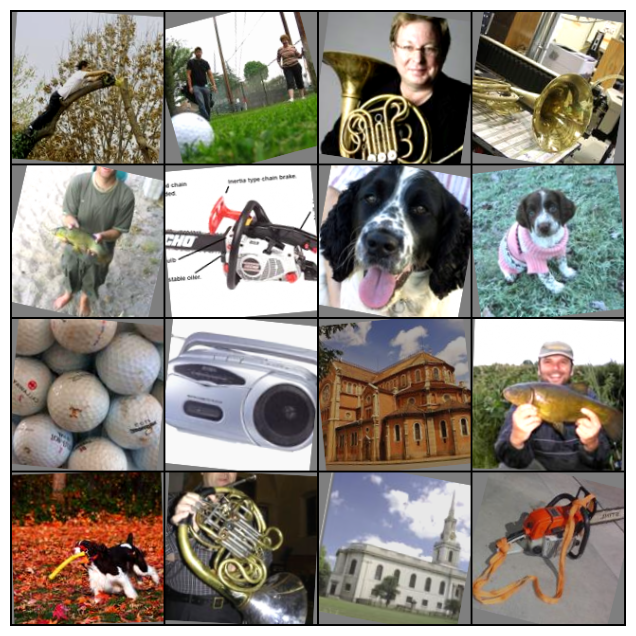

In [376]:
def cell():
    import matplotlib.pyplot as plt
    
    K = 16
    Ks = (K ** 0.5).__ceil__()
    
    plt.figure(figsize=(2*Ks,2*Ks))
    plt.axis('off')
    images = [
        datasHandler.full_dataset.finalTransform(
            datasHandler.dataset_train[i]['image']) for i in range(K)]
    print((sum(img.mean().item() for img in images)/len(images)))
    print((sum(img.std().item() for img in images)/len(images)))
    plt.imshow(torchvision.utils.make_grid(
        images, nrow=Ks, normalize=True, scale_each=False).permute((1, 2, 0)))
    plt.show()

cell(); del cell

In [367]:
model = moeModel = MoE_models.paper2.VisionModelMoe.get_imNette160_v1(
    nbClasses=datasHandler.nbClasses, wImp=0.1, wLoad=0.1,
    nbExperts=6, topK=2, modelConfig="medium", memoryMode=False).to(device)
lossFunc = torch.nn.CrossEntropyLoss().to(device)
optim = torch.optim.AdamW(model.parameters(), lr=0.001)

#print(f"nbParams total: {basicModels.countTotalParameters(model.parameters()):_d}")
#basicModels.countLayersparameters(model)
modelsParameters.ModelTreeNode("Model", model).print(showTrainable=False, end=("experts", "gating", "Block_CNN"))

trainer = train.TrainerClassif_MoE2(model=model, optimizer=optim, criterion=lossFunc, device=device)

# test the model
testImg = datasHandler.full_dataset.finalTransform(datasHandler.full_dataset[0]['image'])
_ = model(testImg.to(device)[None, ...].repeat((1, 1, 1, 1)))
#print(_[0].detach().cpu().numpy())
#print(_[1].detach().cpu().numpy())
#print(_[2].detach().cpu().numpy())

└── Model: 855_096 params
    └── blocks: 855_096 params
        ├── Block_CNN[0]: 432 params
        ├── Block_CNN[1]: 4_672 params
        ├── Block_CNN[2]: 9_216 params
        ├── Block_CNN[3]: 18_432 params
        ├── Block_CNN[4]: 73_728 params
        ├── Block_CNN[5]: 221_568 params
        ├── Dropout[6]: 0 params
        ├── Flatten[7]: 0 params
        ├── Linear[8]: 98_432 params
        └── Block_FFD_Moe[9]: 428_616 params
            ├── gating: 1_548 params
            └── experts: 427_068 params


In [368]:
trainer.train_model_classif(datasHandler=datasHandler, nbEpoches=25);

Epoch 1, train: (loss: 2.322, accuracy: 16.31%), test: (loss: 2.315, accuracy: 16.05%), lr: 1.0000e-03
Epoch 2, train: (loss: 2.102, accuracy: 26.08%), test: (loss: 2.426, accuracy: 14.14%), lr: 1.0000e-03
Epoch 3, train: (loss: 1.898, accuracy: 34.81%), test: (loss: 1.994, accuracy: 31.59%), lr: 1.0000e-03
Epoch 4, train: (loss: 1.759, accuracy: 39.17%), test: (loss: 2.64, accuracy: 24.08%), lr: 1.0000e-03
Epoch 5, train: (loss: 1.626, accuracy: 44.11%), test: (loss: 1.817, accuracy: 40.76%), lr: 1.0000e-03
Epoch 6, train: (loss: 1.497, accuracy: 48.57%), test: (loss: 1.813, accuracy: 40.76%), lr: 1.0000e-03
Epoch 7, train: (loss: 1.439, accuracy: 52.10%), test: (loss: 2.043, accuracy: 38.09%), lr: 1.0000e-03
Epoch 8, train: (loss: 1.324, accuracy: 56.05%), test: (loss: 1.798, accuracy: 43.69%), lr: 1.0000e-03
Epoch 9, train: (loss: 1.278, accuracy: 56.43%), test: (loss: 1.848, accuracy: 43.95%), lr: 1.0000e-03
Epoch 10, train: (loss: 1.221, accuracy: 58.95%), test: (loss: 1.84, accur

In [369]:
def cell_save():
    from pathlib import Path
    pathModel = Path(r"D:\AI_models\MoE_ARMA_project\saved_medV1Cifar_1exp_...")
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optim.state_dict(), 
        "history": trainer.history}
    torch.save(checkpoint, pathModel)

def cell_load():
    from pathlib import Path
    pathModel = Path(r"D:\AI_models\MoE_ARMA_project\saved_medV1Cifar_1exp_...")
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optim.state_dict(), }
    checkpoint = torch.load(pathModel, weights_only=False)
    model.load_state_dict(checkpoint["model"])
    optim.load_state_dict(checkpoint["optimizer"])
    trainer.history = checkpoint["history"]

#cell_save()
#cell_load()
del cell_save, cell_load

In [370]:
resEval_testNoAugments = trainer.eval_model_classif(
    datas=datasHandler_noAugments.test_cLoader(), 
    nbClasses=datasHandler_noAugments.nbClasses, verbose=True)

In [371]:
print(("\n" + ' '*8).join(map(str, trainer.history)))
def cell():
    bestTrain = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].train.accuracy())]
    bestTest = trainer.history[max(range(len(trainer.history)), key=lambda i:trainer.history[i].test.accuracy())]
    print(' ' * 4 + f"-> best accuracy, train: {bestTrain.train.accuracy():.2%} (epoch {bestTrain.epochID}), "
          f"test: {bestTest.test.accuracy():.2%} (epoch {bestTest.epochID})")
    ttTime, trainTime, testTime = trainer.history.totalTimes()
    print(f"eval (test) with no augments: {resEval_testNoAugments}")
    print(f"totalTime: {prettyTime(ttTime)}, trainTime: {prettyTime(trainTime)}, testTime: {prettyTime(testTime)}")
cell(); del cell

Epoch 1, train: (loss: 2.322, accuracy: 16.31%), test: (loss: 2.315, accuracy: 16.05%), lr: 1.0000e-03
        Epoch 2, train: (loss: 2.102, accuracy: 26.08%), test: (loss: 2.426, accuracy: 14.14%), lr: 1.0000e-03
        Epoch 3, train: (loss: 1.898, accuracy: 34.81%), test: (loss: 1.994, accuracy: 31.59%), lr: 1.0000e-03
        Epoch 4, train: (loss: 1.759, accuracy: 39.17%), test: (loss: 2.64, accuracy: 24.08%), lr: 1.0000e-03
        Epoch 5, train: (loss: 1.626, accuracy: 44.11%), test: (loss: 1.817, accuracy: 40.76%), lr: 1.0000e-03
        Epoch 6, train: (loss: 1.497, accuracy: 48.57%), test: (loss: 1.813, accuracy: 40.76%), lr: 1.0000e-03
        Epoch 7, train: (loss: 1.439, accuracy: 52.10%), test: (loss: 2.043, accuracy: 38.09%), lr: 1.0000e-03
        Epoch 8, train: (loss: 1.324, accuracy: 56.05%), test: (loss: 1.798, accuracy: 43.69%), lr: 1.0000e-03
        Epoch 9, train: (loss: 1.278, accuracy: 56.43%), test: (loss: 1.848, accuracy: 43.95%), lr: 1.0000e-03
        Ep

In [372]:
def cell():
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        htest2 = assertIsinstance(train.Moe2ExpertsInsigths, trainer.history[-1].test.moeExpertsInsigths)
        for htest in htest2.expertsInsigths:
            print(f"-> RESULT")
            a: numpy.ndarray = htest.meanExpertsGate()
            b: numpy.ndarray = htest.meanPredClassesExpertsGate().std(axis=0)
            print(f"mean: {a.round(3)} (std: {a.std(axis=0).round(3)})")
            print(f"std: {b.round(3)} (mean: {b.mean().round(3)})")
            print(f"perClassPred: \n{htest.meanPredClassesExpertsGate().round(2).T}")
            print("\n")
        
        rnd = 2
        htests: list[list] = [] # list per MoE of list of htest
        htrains: list[list] = [] # list per MoE of list of htrain
        for i, h in enumerate(trainer.history):
            htest2 = assertIsinstance(train.Moe2ExpertsInsigths, h.test.moeExpertsInsigths)
            htrain2 = assertIsinstance(train.Moe2ExpertsInsigths, h.train.moeExpertsInsigths)
            for i2, (htest, htrain) in enumerate(zip(htest2.expertsInsigths, htrain2.expertsInsigths)):
                if i == 0:
                    htests.append([htest])
                    htrains.append([htrain])
                else: 
                    htests[i2].append(htest)
                    htrains[i2].append(htrain)
        for moe_htrains, moe_htests in zip(htrains, htests):
            for epoch, (htrain, htest) in enumerate(zip(moe_htrains, moe_htests), start=1):
                print(" ->", epoch)
                #print(htest.nbPred.round(rnd))
                #print(htest.nbTruth.round(rnd))
                print("delta (nbPred-nbTruth) per class[test]:\n ", (htest.nbPred - htest.nbTruth), sep="")
                print("mean experts use[train]: ", htrain.meanExpertsGate().round(rnd), sep="")
                print("mean experts use[test]: ", htest.meanExpertsGate().round(rnd), sep="")
                print("mean experts use per class predicted [test]:\n", htest.meanPredClassesExpertsGate().round(rnd).T, sep="")
                print("std experts use acros classes [test]:\n ", htest.meanPredClassesExpertsGate().std(axis=0).round(rnd), sep="")
                #print(htest.meanTruthClassesExpertsGate().round(rnd).T)
                #print((htest.meanPredClassesExpertsGate() - htest.meanTruthClassesExpertsGate()).round(rnd).T)
                print()
    

cell(); del cell

-> RESULT
mean: [0.319 0.101 0.096 0.168 0.178 0.138] (std: 0.075)
std: [0.212 0.172 0.196 0.237 0.275 0.135] (mean: 0.205)
perClassPred: 
[[0.14 0.23 0.   0.27 0.67 0.14 0.02 0.58 0.12 0.12]
 [0.04 0.09 0.   0.34 0.11 0.57 0.07 0.08 0.02 0.  ]
 [0.7  0.1  0.04 0.08 0.03 0.17 0.06 0.01 0.09 0.  ]
 [0.03 0.01 0.13 0.03 0.12 0.   0.07 0.12 0.48 0.77]
 [0.04 0.11 0.79 0.06 0.07 0.1  0.7  0.12 0.03 0.01]
 [0.05 0.46 0.04 0.22 0.   0.03 0.08 0.09 0.26 0.1 ]]


 -> 1
delta (nbPred-nbTruth) per class[test]:
 [-46 -86 -67 -45  -5 127   8  72 -53  95]
mean experts use[train]: [0.19 0.23 0.24 0.02 0.09 0.23]
mean experts use[test]: [0.11 0.22 0.23 0.08 0.2  0.16]
mean experts use per class predicted [test]:
[[0.35  nan 0.24 0.39 0.18 0.09 0.   0.02 0.23 0.15]
 [0.02  nan 0.   0.22 0.08 0.5  0.04 0.18 0.39 0.06]
 [0.34  nan 0.   0.   0.17 0.27 0.34 0.24 0.24 0.15]
 [0.08  nan 0.   0.   0.11 0.01 0.   0.19 0.02 0.12]
 [0.    nan 0.76 0.16 0.44 0.09 0.45 0.09 0.12 0.25]
 [0.2   nan 0.   0.23 0.01 0

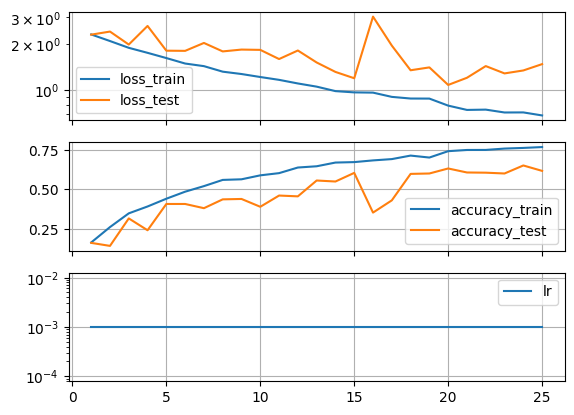

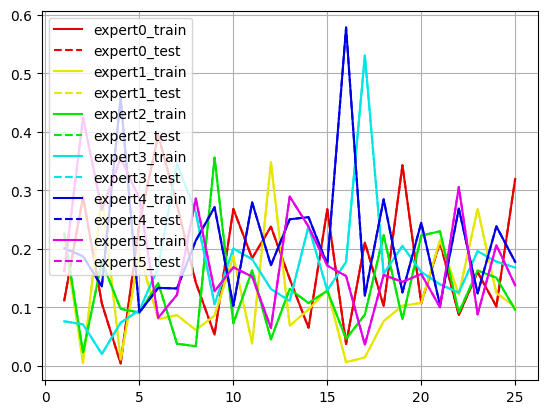

In [373]:
train.HistoryClassification(trainer.history[:]).plot()
trainer.history.plotMoe2Insigths()

In [374]:
def cell():
    conf = trainer.history[-1].test.confusionMatrix
    #print(conf.matrix[0, :].T)
    #print(conf.matrix[65, 65], conf.matrix[65, :])
    
    with numpy.printoptions(threshold=100_000, linewidth=100_000):
        print(conf.matrix)
    print()

    for clsIndex in range(datasHandler.nbClasses):
        print(f"class: {clsIndex}, precision:{conf.classPrecision(clsIndex):.2%}, "
              f"hitRate: {conf.classHitRate(clsIndex):.2%}")
    print()
    
    prettyPrint(conf.worstK_confusions(10), 
                specificCompact={tuple}, specificFormats={numpy.float64:lambda x:f"{x:.4g}"})
cell(); del cell

[[48  1  2  3  0  2  0  0  1  0]
 [ 2 68  2  5  2  8  2  1  2  0]
 [ 1  0 34  2  0  1  1  2  2  1]
 [ 4  0  1 32  0 17  3  0  2  5]
 [ 1  0  3  5 66 22  5  7  9 12]
 [ 0  0  1  0  0 17  0  0  0  0]
 [ 0  5  5  3  0  3 55  3  1  3]
 [ 3 10 20 20  9 14 17 64  9  2]
 [ 7  1  0  3  0  2  1  0 54  3]
 [ 1  1  0  4  2  0  0  0  8 47]]

class: 0, precision:84.21%, hitRate: 71.64%
class: 1, precision:73.91%, hitRate: 79.07%
class: 2, precision:77.27%, hitRate: 50.00%
class: 3, precision:50.00%, hitRate: 41.56%
class: 4, precision:50.77%, hitRate: 83.54%
class: 5, precision:94.44%, hitRate: 19.77%
class: 6, precision:70.51%, hitRate: 65.48%
class: 7, precision:38.10%, hitRate: 83.12%
class: 8, precision:76.06%, hitRate: 61.36%
class: 9, precision:74.60%, hitRate: 64.38%

[
    (0.07333333333333333, 5, 4),
    (0.06666666666666667, 3, 7),
    (0.06666666666666667, 2, 7),
    (0.056666666666666664, 6, 7),
    (0.056666666666666664, 5, 3),
    (0.04666666666666667, 5, 7),
    (0.04, 9, 4),
    (0.

In [375]:
import winsound
winsound.Beep(200, 3000)  # frequency in Hz, duration in ms